In [1]:
from moption import options
import moption.black_sholes as bs
from moption import tools 

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import copy

This notebook is written primarily to test the functionalities of the `black_sholes` module in the `moption` library and its relevant modules. In doing so, we also review some useful knowledge about options and the black-sholes-merton model.  

# Price and Greeks of an Option 

We can create an vanilla European option with the `VanillaOption` class in `options` module. It's the standard option for Black-sholes pricing formula. The constructor requires seven parameters: 

- Underlying price `S`
- Strike price `K`
- Time to maturity `t`
- Annualized volatility `sigma`
- Annualized interest rate `r`
- Continuous dividend paying rate `q`
- Bool-type varaible `put` to specify this option is a put or not. 

The first four parameters must be given while the last there have default values.  

In [2]:
# create a call without dividends
call = options.VanillaOption(100, 100, 0.5, 0.3, 0.02)
# show the information about it
call.summary()

Call Option
Underlying Price =  100.0
Underlying Volatility =  30.0 %
Strike Price =  100.0
Time to Maturity =  0.5 years
Interest Rate =  2.0 %


We can change some attributes of an option object to get a new option. For example, we can get a new call option with dividend paying, or a new option that is a put while everything else is the same as our call option.

In [3]:
# creat a call with dividends
q = 0.04
call_div = options.VanillaOption(call.S, call.K, call.t, call.sigma, 
                                 call.r, q)
call_div.summary()
# you can also do
call.div = call.shock(q_shock = q)
# or
call.div = call.set_param(q, param='q')

Call Option
Underlying Price =  100.0
Underlying Volatility =  30.0 %
Strike Price =  100.0
Time to Maturity =  0.5 years
Interest Rate =  2.0 %
Divident Paying Rate =  4.0 %


In [4]:
# creat the put counterpart of these two options （two ways）
put = call.change_type()
put_div = call_div.shock(type_change = True)

## 1. Black-sholes Pricing

Black-sholes related pricing and greeks functions are in the `black_sholes` module. The formulas are given by:

$$C(S_t, t) = S_te^{-qt}N(d1) - Ke^{-rt}N(d2)$$
$$P(S_t, t) = Ke^{-rt}N(-d2) - S_te^{-qt}N(-d1)$$
$$d_1 = \frac{1}{\sigma\sqrt{t}} [\ln\frac{S_t}{K}+(r-q+\frac{1}{2}\sigma^2)t]$$
$$d_2 = \frac{1}{\sigma\sqrt{t}} [\ln\frac{S_t}{K}+(r-q-\frac{1}{2}\sigma^2)t]$$

In [5]:
# show the prices of these four options
print("Call price:", round(bs.pricing(call), 4))
print("Call price, with dividends:", round(bs.pricing(call_div), 4))
print("Put price:", round(bs.pricing(put), 4))
print("Put price, with dividends:", round(bs.pricing(put_div), 4))

Call price: 8.9118
Call price, with dividends: 7.838
Put price: 7.9168
Put price, with dividends: 8.8231


`Tools` module provides functions for some useful analysis. For example, we can use `scenario_analysis` to get the prices of an option position under different underlying price scenarios.

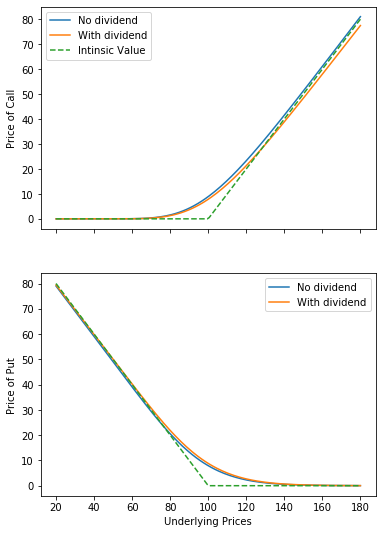

In [6]:
# see how price changes with different underlying prices
s_range = np.linspace(20,180,162)
call_prices = tools.scenario_analysis(call, bs.pricing, vrange = s_range)
call_div_prices = tools.scenario_analysis(call_div, bs.pricing, vrange = s_range)
put_prices = tools.scenario_analysis(put, bs.pricing, vrange = s_range)
put_div_prices = tools.scenario_analysis(put_div, bs.pricing, vrange = s_range)
# plot
fig, ax = plt.subplots(2, 1, sharex=True, figsize = (6,9))
ax[0].plot(s_range, call_prices, label = 'No dividend')
ax[0].plot(s_range, call_div_prices, label = "With dividend")
ax[0].plot(s_range, np.maximum(s_range-call.K, 0), label = 'Intinsic Value', linestyle = 'dashed')
ax[0].legend()
ax[0].set_ylabel("Price of Call")

ax[1].plot(s_range, put_prices, label = 'No dividend')
ax[1].plot(s_range, put_div_prices, label = "With dividend")
ax[1].legend()
ax[1].plot(s_range, np.maximum(-s_range+call.K, 0), label = 'Intinsic Value', linestyle = 'dashed')
ax[1].set_ylabel("Price of Put")

plt.xlabel("Underlying Prices")
plt.show()
plt.show()

As we can see, the dividend makes a call less valuable while makes a put more valuable. This makes sense since the dividend paying is a benefit of carrying a stock. Therefore the stock price is expected to drop with higher dividend, thus implying lower call premiums and higher put premiums.

For deep in-the-money puts and deep in-the-money calls with dividend, the option prices can even be lower than the intrinsic value, suggesting an early exercise for the American option counterparts.

We can also see how the price curve involves as time passes by.

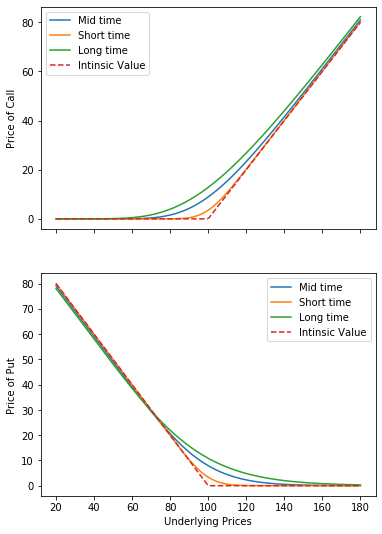

In [7]:
call_prices_st = tools.scenario_analysis(call.set_param(new_value = 1/12, param = 't'), 
                                         bs.pricing, vrange = s_range)
call_prices_lt = tools.scenario_analysis(call.set_param(new_value = 1, param = 't'), 
                                         bs.pricing, vrange = s_range)
put_prices_st = tools.scenario_analysis(put.set_param(new_value = 1/12, param = 't'), 
                                         bs.pricing, vrange = s_range)
put_prices_lt = tools.scenario_analysis(put.set_param(new_value = 1, param = 't'), 
                                         bs.pricing, vrange = s_range)

# plot
fig, ax = plt.subplots(2, 1, sharex=True, figsize = (6,9))
ax[0].plot(s_range, call_prices, label = 'Mid time')
ax[0].plot(s_range, call_prices_st, label = "Short time")
ax[0].plot(s_range, call_prices_lt, label = "Long time")
ax[0].plot(s_range, np.maximum(s_range-call.K, 0), label = 'Intinsic Value', linestyle = 'dashed')
ax[0].legend()
ax[0].set_ylabel("Price of Call")

ax[1].plot(s_range, put_prices, label = 'Mid time')
ax[1].plot(s_range, put_prices_st, label = "Short time")
ax[1].plot(s_range, put_prices_lt, label = "Long time")
ax[1].plot(s_range, np.maximum(-s_range+put.K, 0), label = 'Intinsic Value', linestyle = 'dashed')
ax[1].legend()
ax[1].set_ylabel("Price of Put")

plt.xlabel("Underlying Prices")
plt.show()
plt.show()

We can also see how volatility affects the prices.

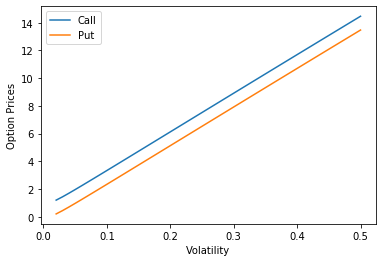

In [8]:
sig_range = np.linspace(2, 50, 49)/100

call_prices = tools.scenario_analysis(call, bs.pricing,
                                    variable = 'sigma', vrange = sig_range)
put_prices = tools.scenario_analysis(put, bs.pricing,
                                    variable = 'sigma', vrange = sig_range)
# plot

plt.plot(sig_range, call_prices, label = 'Call')
plt.plot(sig_range, put_prices, label = 'Put')
plt.legend()
plt.xlabel("Volatility")
plt.ylabel("Option Prices")
plt.show()

It's almost a linear function.

## 2. Black-sholes Greeks
The `greeks` function in the `black_sholes` module gives the greeks summary by a dictionary. We can also get as a specific greek by call the corresponding function.

In [9]:
# get a summary of greeks information
print(bs.greeks(call))

# get vega
print('Vega of the call with dividends: ', bs.vega(call_div))

# get vanna
print('Vanna of the call with dividends: ', bs.vanna(put))

{'Delta': 0.5608822719131072, 'Gamma': 0.01858689650151456, 'Theta': -9.307632199280889, 'Vega': 27.880344752271846, 'Rho': 23.588219339983386, 'Speed': -0.00032010766197052855, 'Vanna': 0.077445402089644, 'Volga': -0.8389918559711435, 'Charm': 0.06040741362992232, 'Color': 0.019023172266619558, 'Zomma': -0.06251564957569598, 'Phi': -28.04411359565536}
Vega of the call with dividends:  27.60293068685623
Vanna of the call with dividends:  0.077445402089644


Similar to our scenario analysis for prices, we can also see how the greeks change with different option pricing parameters by using `tools.scenario_analysis`. Let's explore some deltas in details wih this function.

### (1) Delta
First, see how change in the underlying prices affect deltas.

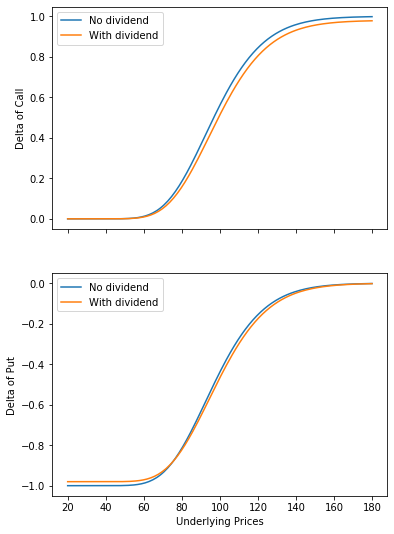

In [10]:
# see how delta changes with different underlying prices
call_deltas = tools.scenario_analysis(call, bs.delta, vrange = s_range)
call_div_deltas = tools.scenario_analysis(call_div, bs.delta, vrange = s_range)
put_deltas = tools.scenario_analysis(put, bs.delta, vrange = s_range)
put_div_deltas = tools.scenario_analysis(put_div, bs.delta, vrange = s_range)
# plot
fig, ax = plt.subplots(2, 1, sharex=True, figsize = (6,9))
ax[0].plot(s_range, call_deltas, label = 'No dividend')
ax[0].plot(s_range, call_div_deltas, label = "With dividend")
ax[0].legend()
ax[0].set_ylabel("Delta of Call")

ax[1].plot(s_range, put_deltas, label = 'No dividend')
ax[1].plot(s_range, put_div_deltas, label = "With dividend")
ax[1].legend()
ax[1].set_ylabel("Delta of Put")

plt.xlabel("Underlying Prices")
plt.show()

Note dividend plays two roles here. First it affects the forward price, which decides the probability that the option ends up in the money; second it affects the difference of cost in carrying the option and carring the underlying stock. As a result, the dividend just makes call's delta decreases; while for puts, the influences are different for ITM and OTM options.  

Then see how delta value changes as volatility changes.

In [11]:
# get several new options
call_otm = call.shock(K_shock = 10)
call_itm = call.shock(K_shock = -10)
put_otm = put.shock(K_shock = -10)
put_itm = put.shock(K_shock = 10)

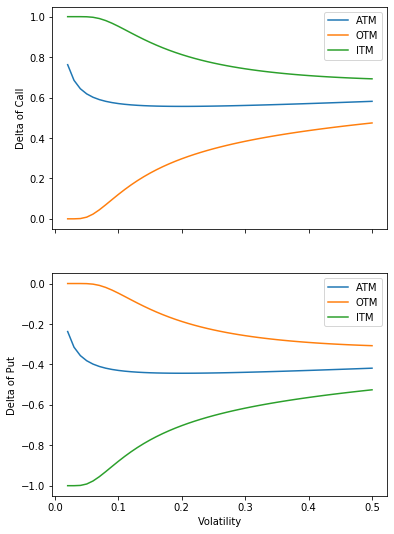

In [12]:
call_atm_deltas = tools.scenario_analysis(call, bs.delta,
                                          variable = 'sigma', vrange = sig_range)
call_otm_deltas = tools.scenario_analysis(call_otm, bs.delta,
                                          variable = 'sigma', vrange = sig_range)
call_itm_deltas = tools.scenario_analysis(call_itm, bs.delta, 
                                         variable = 'sigma', vrange = sig_range)
put_atm_deltas = tools.scenario_analysis(put, bs.delta,
                                          variable = 'sigma', vrange = sig_range)
put_otm_deltas = tools.scenario_analysis(put_otm, bs.delta,
                                        variable = 'sigma', vrange = sig_range)
put_itm_deltas = tools.scenario_analysis(put_itm, bs.delta,
                                        variable = 'sigma', vrange = sig_range)
# plot
fig, ax = plt.subplots(2, 1, sharex=True, figsize = (6,9))
ax[0].plot(sig_range, call_atm_deltas, label = 'ATM')
ax[0].plot(sig_range, call_otm_deltas, label = "OTM")
ax[0].plot(sig_range, call_itm_deltas, label = "ITM")
ax[0].legend()
ax[0].set_ylabel("Delta of Call")

ax[1].plot(sig_range, put_atm_deltas, label = 'ATM')
ax[1].plot(sig_range, put_otm_deltas, label = "OTM")
ax[1].plot(sig_range, put_itm_deltas, label = "ITM")
ax[1].legend()
ax[1].set_ylabel("Delta of Put")

plt.xlabel("Volatility")
plt.show()

For ATM options, the delta first decreases than increases slightly. Some textbooks give graphs in which the ATM delta keeps increasing as volatilty increases. The initial drop in our plots comes from the effect of interest rate. The `d1` parameter for ATM option in the black-sholes model is a function of $x+\frac{1}{x}$ form with respect to $\sigma$, but when $r=0$, it degenerates to a linear function. 

Intuitively, when the voloatility is very low while there is an non-ignorable interest payment, the underlying asset is almost risk-free. It also has a forward price higher than the current price because of the interest rate. Therefore, ATM call is actually "in-the-money" in terms of forward prices. Since what really matters is the forward price, the ATM option behaves like an ITM option under this situation.

The statement above is illustrated below.

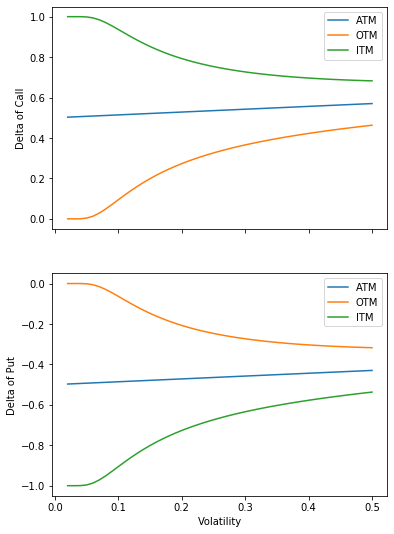

In [13]:
call_atm_deltas = tools.scenario_analysis(call.set_param(param = 'r', new_value = 0), bs.delta,
                                          variable = 'sigma', vrange = sig_range)
call_otm_deltas = tools.scenario_analysis(call_otm.set_param(param = 'r', new_value = 0), bs.delta,
                                          variable = 'sigma', vrange = sig_range)
call_itm_deltas = tools.scenario_analysis(call_itm.set_param(param = 'r', new_value = 0), bs.delta, 
                                         variable = 'sigma', vrange = sig_range)
put_atm_deltas = tools.scenario_analysis(put.set_param(param = 'r', new_value = 0), bs.delta,
                                          variable = 'sigma', vrange = sig_range)
put_otm_deltas = tools.scenario_analysis(put_otm.set_param(param = 'r', new_value = 0), bs.delta,
                                        variable = 'sigma', vrange = sig_range)
put_itm_deltas = tools.scenario_analysis(put_itm.set_param(param = 'r', new_value = 0), bs.delta,
                                        variable = 'sigma', vrange = sig_range)
# plot
fig, ax = plt.subplots(2, 1, sharex=True, figsize = (6,9))
ax[0].plot(sig_range, call_atm_deltas, label = 'ATM')
ax[0].plot(sig_range, call_otm_deltas, label = "OTM")
ax[0].plot(sig_range, call_itm_deltas, label = "ITM")
ax[0].legend()
ax[0].set_ylabel("Delta of Call")

ax[1].plot(sig_range, put_atm_deltas, label = 'ATM')
ax[1].plot(sig_range, put_otm_deltas, label = "OTM")
ax[1].plot(sig_range, put_itm_deltas, label = "ITM")
ax[1].legend()
ax[1].set_ylabel("Delta of Put")

plt.xlabel("Volatility")
plt.show()

The sensitivity of the delta to a change in volatility is sometimes referred to as `vanna`; the sensitivity of the delta to a change in time is referred to as `charm` or `delta decay`. Because of the similar role that time to maturity and volatility is playing, the delta change as time passes is similar to the delta-volatility graph above. 

In the graph below, we present the delta's change to time in a different view. 

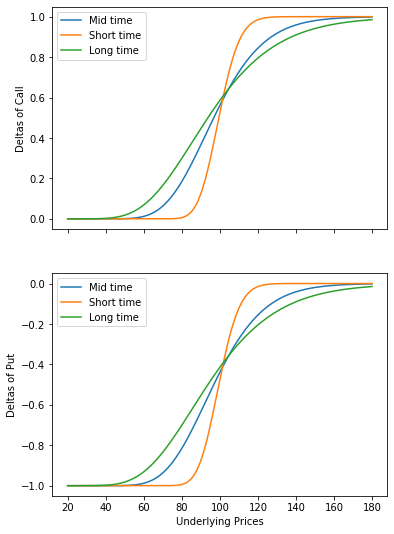

In [14]:
call_deltas_st = tools.scenario_analysis(call.set_param(new_value = 1/12, param = 't'), 
                                         bs.delta, vrange = s_range)
call_deltas_lt = tools.scenario_analysis(call.set_param(new_value = 1, param = 't'), 
                                         bs.delta, vrange = s_range)
put_deltas_st = tools.scenario_analysis(put.set_param(new_value = 1/12, param = 't'), 
                                         bs.delta, vrange = s_range)
put_deltas_lt = tools.scenario_analysis(put.set_param(new_value = 1, param = 't'), 
                                         bs.delta, vrange = s_range)

# plot
fig, ax = plt.subplots(2, 1, sharex=True, figsize = (6,9))
ax[0].plot(s_range, call_deltas, label = 'Mid time')
ax[0].plot(s_range, call_deltas_st, label = "Short time")
ax[0].plot(s_range, call_deltas_lt, label = "Long time")
ax[0].legend()
ax[0].set_ylabel("Deltas of Call")

ax[1].plot(s_range, put_deltas, label = 'Mid time')
ax[1].plot(s_range, put_deltas_st, label = "Short time")
ax[1].plot(s_range, put_deltas_lt, label = "Long time")
ax[1].legend()
ax[1].set_ylabel("Deltas of Put")

plt.xlabel("Underlying Prices")
plt.show()
plt.show()

We can also directly look at the `vanna` and `charm`.

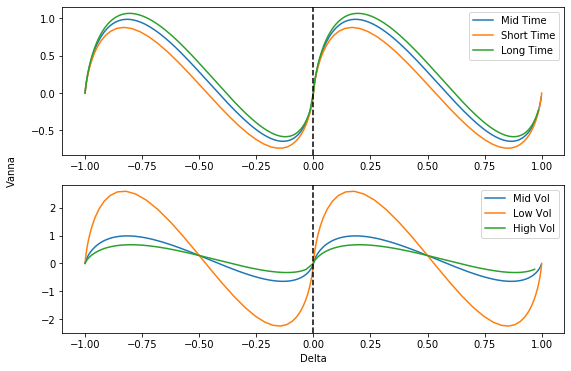

In [15]:
# calculations
put_vannas = tools.scenario_analysis(put, bs.vanna, vrange = s_range)
call_vannas = tools.scenario_analysis(call, bs.vanna, vrange = s_range)

put_vannas_st = tools.scenario_analysis(put.set_param(new_value = 1/12, param = 't'), 
                                        bs.vanna, vrange = s_range)
call_vannas_st = tools.scenario_analysis(call.set_param(new_value = 1/12, param = 't'), 
                                         bs.vanna, vrange = s_range)

put_vannas_lt = tools.scenario_analysis(put.set_param(new_value = 1, param = 't'), 
                                        bs.vanna, vrange = s_range)
call_vannas_lt = tools.scenario_analysis(call.set_param(new_value = 1, param = 't'), 
                                         bs.vanna, vrange = s_range)

put_vannas_lowvol = tools.scenario_analysis(put.set_param(new_value = 0.1, param = 'sigma'), 
                                        bs.vanna, vrange = s_range)
call_vannas_lowvol = tools.scenario_analysis(call.set_param(new_value = 0.1, param = 'sigma'), 
                                         bs.vanna, vrange = s_range)

put_vannas_highvol = tools.scenario_analysis(put.set_param(new_value = 0.5, param = 'sigma'), 
                                        bs.vanna, vrange = s_range)
call_vannas_highvol = tools.scenario_analysis(call.set_param(new_value = 0.5, param = 'sigma'), 
                                         bs.vanna, vrange = s_range)

put_deltas_lowvol = tools.scenario_analysis(put.set_param(new_value = 0.1, param = 'sigma'), 
                                        bs.delta, vrange = s_range)
call_deltas_lowvol = tools.scenario_analysis(call.set_param(new_value = 0.1, param = 'sigma'), 
                                         bs.delta, vrange = s_range)

put_deltas_highvol = tools.scenario_analysis(put.set_param(new_value = 0.5, param = 'sigma'), 
                                        bs.delta, vrange = s_range)
call_deltas_highvol = tools.scenario_analysis(call.set_param(new_value = 0.5, param = 'sigma'), 
                                         bs.delta, vrange = s_range)

# plot
fig, ax = plt.subplots(2,1, figsize = (9,6))
ax[0].plot(np.hstack([put_deltas,call_deltas]), np.hstack([put_vannas, call_vannas]),
        label = 'Mid Time')
ax[0].plot(np.hstack([put_deltas_st,call_deltas_st]), np.hstack([put_vannas_st, call_vannas_st]),
        label = 'Short Time')
ax[0].plot(np.hstack([put_deltas_lt,call_deltas_lt]), np.hstack([put_vannas_lt, call_vannas_lt]),
        label = 'Long Time')
ax[0].axvline(color='black', linestyle = 'dashed')
ax[0].legend()

ax[1].plot(np.hstack([put_deltas,call_deltas]), np.hstack([put_vannas, call_vannas]),
        label = 'Mid Vol')
ax[1].plot(np.hstack([put_deltas_lowvol,call_deltas_lowvol]), 
         np.hstack([put_vannas_lowvol, call_vannas_lowvol]), label = 'Low Vol')
ax[1].plot(np.hstack([put_deltas_highvol,call_deltas_highvol]), 
         np.hstack([put_vannas_highvol, call_vannas_highvol]), label = 'High Vol')
plt.xlabel("Delta")
fig.text(0.04, 0.5, "Vanna", va='center', rotation='vertical')
plt.axvline(color='black', linestyle = 'dashed')
ax[1].legend()
plt.show()

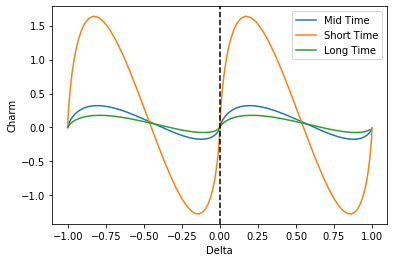

In [16]:
put_charms = tools.scenario_analysis(put, bs.charm, vrange = s_range)
call_charms = tools.scenario_analysis(call, bs.charm, vrange = s_range)

put_charms_st = tools.scenario_analysis(put.set_param(new_value = 1/12, param = 't'), 
                                        bs.charm, vrange = s_range)
call_charms_st = tools.scenario_analysis(call.set_param(new_value = 1/12, param = 't'), 
                                         bs.charm, vrange = s_range)

put_charms_lt = tools.scenario_analysis(put.set_param(new_value = 1, param = 't'), 
                                        bs.charm, vrange = s_range)
call_charms_lt = tools.scenario_analysis(call.set_param(new_value = 1, param = 't'), 
                                         bs.charm, vrange = s_range)

plt.plot(np.hstack([put_deltas,call_deltas]), np.hstack([put_charms, call_charms]),
        label = 'Mid Time')
plt.plot(np.hstack([put_deltas_st,call_deltas_st]), np.hstack([put_charms_st, call_charms_st]),
        label = 'Short Time')
plt.plot(np.hstack([put_deltas_lt,call_deltas_lt]), np.hstack([put_charms_lt, call_charms_lt]),
        label = 'Long Time')
plt.axvline(color='black', linestyle = 'dashed')
plt.xlabel('Delta')
plt.ylabel('Charm')
plt.legend()
plt.show()

### (2) Theta
Now let's take a look at the properties of theta.

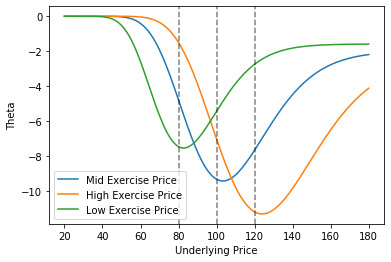

In [17]:
call_thetas = tools.scenario_analysis(call, bs.theta, vrange = s_range)
call_thetas_highK = tools.scenario_analysis(call.shock(K_shock = 20), 
                                            bs.theta, vrange = s_range)
call_thetas_lowK = tools.scenario_analysis(call.shock(K_shock = -20), 
                                            bs.theta, vrange = s_range)

plt.plot(s_range, call_thetas, label = 'Mid Exercise Price')
plt.plot(s_range, call_thetas_highK, label = 'High Exercise Price')
plt.plot(s_range, call_thetas_lowK, label = 'Low Exercise Price')
plt.xlabel("Underlying Price")
plt.ylabel("Theta")
plt.axvline(call.K, linestyle = 'dashed', color = 'black', alpha = 0.5)
plt.axvline(call.shock(K_shock = 20).K, linestyle = 'dashed', 
            color = 'black', alpha = 0.5)
plt.axvline(call.shock(K_shock = -20).K, linestyle = 'dashed', 
            color = 'black', alpha = 0.5)
plt.legend()
plt.show()

ATM options have the highest theta. As underlying prices increase, the ATM thetas increase almost linearly. This makes sense since with higher underlying price, the ATM options worth higher, thus having more value to decay, which means a higher theta.

Mathematicall, $N(d_1)$ and $N(d_2)$ in the black-sholes formula is the same for ATM options that only differ in the underlying prices. Therefore, $Se^{-qt}N(d_1)-Ke^{-rt}N(d_2)$ is a linear function of the underlying price. Theta should be higher to decay the value. (we can also analyze the theta formula directly, the key is still that $d_1$ and $d_2$ is the same for different ATM options) 

Then we take a look at how the option value changes as time to maturity changes.

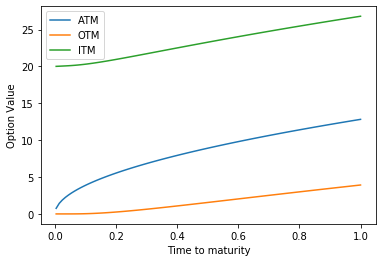

In [18]:
t_range = np.linspace(1/252, 1, num = 100)
call_prices = tools.scenario_analysis(call, bs.pricing, vrange = t_range, variable = 't')
call_prices_otm = tools.scenario_analysis(call.shock(S_shock = -20), 
                                          bs.pricing, vrange = t_range, variable = 't')
call_prices_itm = tools.scenario_analysis(call.shock(S_shock = 20), 
                                          bs.pricing, vrange = t_range, variable = 't')
plt.plot(t_range, call_prices, label = "ATM")
plt.plot(t_range, call_prices_otm, label = "OTM")
plt.plot(t_range, call_prices_itm, label = "ITM")
plt.legend()
plt.xlabel("Time to maturity")
plt.ylabel("Option Value")
plt.show()

As we can see, option value is decreasing as option matures. That's why we say "theta decay". The slope reflects theta. For long term options, we can see theta is similar among different options (ATM is actually a little higher). As the option comes to maturity, the ATM theta increases quickly. For ITM/OTM, theta doesn't change much untill right before expiration, the theta goes to 0.

We can verify the statement by plotting the theta directly.

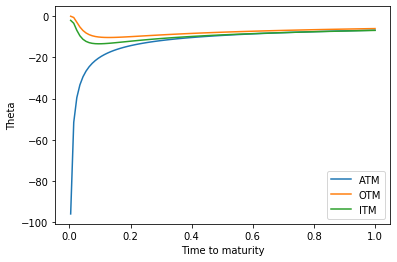

In [19]:
call_thetas = tools.scenario_analysis(call, bs.theta, vrange = t_range, variable = 't')
call_thetas_otm = tools.scenario_analysis(call.shock(S_shock = -10), 
                                          bs.theta, vrange = t_range, variable = 't')
call_thetas_itm = tools.scenario_analysis(call.shock(S_shock = 10), 
                                          bs.theta, vrange = t_range, variable = 't')
plt.plot(t_range, call_thetas, label = "ATM")
plt.plot(t_range, call_thetas_otm, label = "OTM")
plt.plot(t_range, call_thetas_itm, label = "ITM")
plt.legend()
plt.xlabel("Time to maturity")
plt.ylabel("Theta")
plt.show()

We can also see how theta changes as volatility changes.

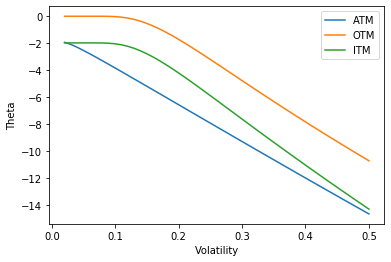

In [20]:
# this time let's code this routine in a different way by using anonymous function
# situation analysis: theta to sigma
sa_theta2sigma = lambda option : tools.scenario_analysis(option, 
                                 bs.theta, vrange = sig_range, variable = 'sigma')
call_thetas_otm, call_thetas, call_thetas_itm = [sa_theta2sigma(call.shock(S_shock = s)) 
                                                 for s in [-20, 0, 20]]
plt.plot(sig_range, call_thetas, label = "ATM")
plt.plot(sig_range, call_thetas_otm, label = "OTM")
plt.plot(sig_range, call_thetas_itm, label = "ITM")
plt.legend()
plt.xlabel("Volatility")
plt.ylabel("Theta")
plt.show()

Higher volatility means higher theta. This is because the higher volatility, the higher the option value, therefore more values to decay. 

### (3) Vega

Vega behaves similar as theta in many ways. This is because longer time is associated with higher volatility. Both longer time to maturity and higher volatility mean more uncertainties.

Like our analysis for theta, first we take a look at how underlying prices influence vega.

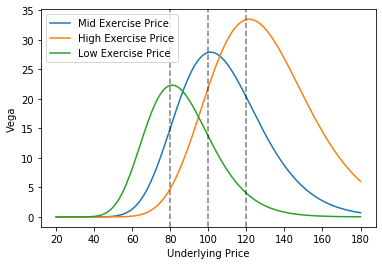

In [21]:
sa_vega2S = lambda option : tools.scenario_analysis(option, 
                                 bs.vega, vrange = s_range, variable = 'S')
call_vegas_lowK, call_vegas, call_vegas_highK = [sa_vega2S(call.shock(K_shock = k)) 
                                                 for k in [-20, 0, 20]]
# plot
plt.plot(s_range, call_vegas, label = 'Mid Exercise Price')
plt.plot(s_range, call_vegas_highK, label = 'High Exercise Price')
plt.plot(s_range, call_vegas_lowK, label = 'Low Exercise Price')
plt.xlabel("Underlying Price")
plt.ylabel("Vega")
plt.axvline(call.K, linestyle = 'dashed', color = 'black', alpha = 0.5)
plt.axvline(call.shock(K_shock = 20).K, linestyle = 'dashed', 
            color = 'black', alpha = 0.5)
plt.axvline(call.shock(K_shock = -20).K, linestyle = 'dashed', 
            color = 'black', alpha = 0.5)
plt.legend()
plt.show()

It does show a similar pattern to theta. Like theta, we find ATM's vega increases linearly as underlying price increases. Mathematically, we have similar explanation as theta. Intuitively, volatility shock matters in percentage terms of price change. Therefore, with higher underlying price, same percentage change means higher dollar value change, which means a higher vega.

In the discussion about `delta`, we talk about its sensitivity to volatility, `vanna`, which also means `vega`'s sensitivity to the underlying price.


We can also have a look at how the volatility change infulences the option value directly.

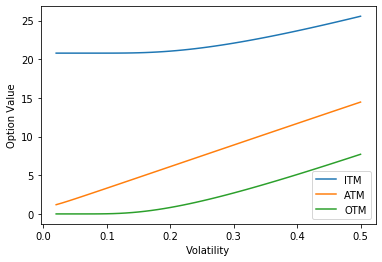

In [22]:
sa_value2sigma = lambda option : tools.scenario_analysis(option, 
                                 bs.pricing, vrange = sig_range, variable = 'sigma')
call_value_itm, call_value, call_value_otm = [sa_value2sigma(call.shock(K_shock = k)) 
                                                 for k in [-20, 0, 20]]
# plot
plt.plot(sig_range, call_value_itm, label = 'ITM')
plt.plot(sig_range, call_value, label = 'ATM')
plt.plot(sig_range, call_value_otm, label = 'OTM')
plt.xlabel("Volatility")
plt.ylabel("Option Value")
plt.legend()
plt.show()

Consistent with the previous analysis, higher volatility means higher option value. ITM value > ATM value > OTM value as a result of difference in intrinsic value. ATM's value changes fast, suggesting the highest vega. We have another two interesting observations we can make use of:

- The patterns for ITM and OTM are similar. When analyze the volatility value of an ITM option, we can use the value of its put/call counterpart (which is OTM) to approximate.

- ATM's value is almost a straight line. This is closely related to a frequently used formula to estimate ATM's value using volatility: $c(S_t, t) = 0.4S\sigma\sqrt{t}$.

The condition for the formula above to work well is that the interest rate and dividend rate are low (or equivalently the option is near expiration). Here is how the math works - for at-the-money option, we have:

$$d_1 = (r-q)\frac{\sqrt{t}}{\sigma}+\frac{1}{2}\sigma\sqrt{t}$$
$$d_2 = (r-q)\frac{\sqrt{t}}{\sigma}-\frac{1}{2}\sigma\sqrt{t}$$

We know: 
$$c(S_t, t) = S_te^{-qt}N(d_1) - Ke^{-rt}N(d_2)$$

If both interest rates and dividend rates are low, $S_te^{-qt}$ and $Ke^{-rt}$ are approximately the underlying price $S$. Therefore,

$$c = S[N(d_1)-N(d_2)] = S\int_{d_2}^{d_1}\frac{1}{\sqrt{2\pi}}e^{-\frac{x^2}{2}}dx$$

With $\frac{1}{\sqrt{2\pi}} \approx 0.4$, and the fact that $(r-q)\frac{\sqrt{t}}{\sigma}$ is around $0$ and normal pdf is about $1$ around $0$, the fourmula above is simply:

$$c = 0.4S\sigma\sqrt{t}$$

The linear function of option value to volatility also means that ATM's vega is invariant to the change of volatility. `Volga` or `vomma` means the sensitivity of vega to volatility. 

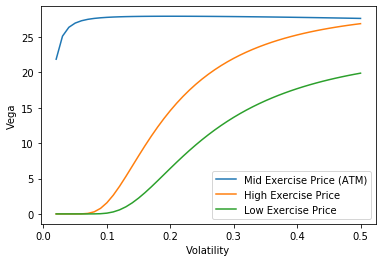

In [23]:
sa_vega2sigma = lambda option : tools.scenario_analysis(option, 
                                 bs.vega, vrange = sig_range, variable = 'sigma')
call_vegas_lowK, call_vegas, call_vegas_highK = [sa_vega2sigma(call.shock(K_shock = k)) 
                                                 for k in [-20, 0, 20]]
# plot
plt.plot(sig_range, call_vegas, label = 'Mid Exercise Price (ATM)')
plt.plot(sig_range, call_vegas_highK, label = 'High Exercise Price')
plt.plot(sig_range, call_vegas_lowK, label = 'Low Exercise Price')
plt.xlabel("Volatility")
plt.ylabel("Vega")
plt.legend()
plt.show()

We find the pattern is not as we expected when volatility is very low. Again, this is because in a low volatility environment, the effect of interest rate and dividend is no longer ignorable in our approximation. If we set both interest rate and dividend paying rate to be 0, we can find:

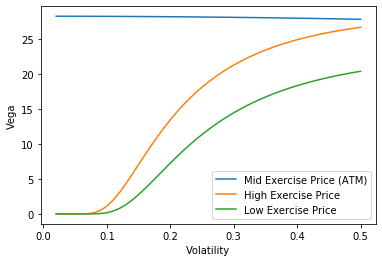

In [24]:
sa_vega2sigma = lambda option : tools.scenario_analysis(option, 
                                 bs.vega, vrange = sig_range, variable = 'sigma')
call_vegas_lowK, call_vegas, call_vegas_highK = [sa_vega2sigma(call.shock(K_shock = k).\
                                                               set_param(param = 'r', new_value = 0)) 
                                                 for k in [-20, 0, 20]]
# plot
plt.plot(sig_range, call_vegas, label = 'Mid Exercise Price (ATM)')
plt.plot(sig_range, call_vegas_highK, label = 'High Exercise Price')
plt.plot(sig_range, call_vegas_lowK, label = 'Low Exercise Price')
plt.xlabel("Volatility")
plt.ylabel("Vega")
plt.legend()
plt.show()

We already know that ATM options' vega is *approximately* a positive constant. Note that the vega of underlying assets is zero under the standard assumptions. For OTM and ITM option, they behave like a worthless paper or an underlying contract when deep OTM/ITM. Even when the underlying price and the strike price stay the same, an option becomes more ATM when volatility is high and vice versa. Therefore, as volatility increases, the vega of OTM/ITM option increase from 0 to ATM option's vega.

We can also take a look at the volga value directly.

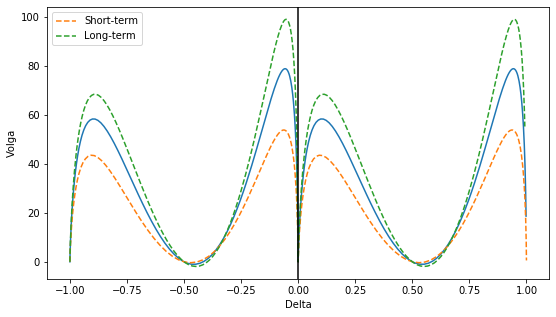

In [25]:
sa_volga2S = lambda option : tools.scenario_analysis(option, bs.volga, vrange = s_range)
sa_delta2S = lambda option : tools.scenario_analysis(option, bs.delta, vrange = s_range)
call_volga = sa_volga2S(call)
call_volga_lt = sa_volga2S(call.set_param(param = 't', new_value = 3/4))
call_volga_st = sa_volga2S(call.set_param(param = 't', new_value = 1/4))
put_volga = sa_volga2S(put)
put_volga_lt = sa_volga2S(put.set_param(param = 't', new_value = 3/4))
put_volga_st = sa_volga2S(put.set_param(param = 't', new_value = 1/4))
call_delta = sa_delta2S(call)
call_delta_lt = sa_delta2S(call.set_param(param = 't', new_value = 3/4))
call_delta_st = sa_delta2S(call.set_param(param = 't', new_value = 1/4))
put_delta = sa_delta2S(put)
put_delta_lt = sa_delta2S(put.set_param(param = 't', new_value = 3/4))
put_delta_st = sa_delta2S(put.set_param(param = 't', new_value = 1/4))


# plot
plt.figure(figsize = (9,5))
plt.plot(np.hstack([put_delta, call_delta]), 
         np.hstack([put_volga, call_volga]))
plt.plot(np.hstack([put_delta_st, call_delta_st]), 
         np.hstack([put_volga_st, call_volga_st]),
        linestyle = 'dashed', label = "Short-term")
plt.plot(np.hstack([put_delta_lt, call_delta_lt]), 
         np.hstack([put_volga_lt, call_volga_lt]),
        linestyle = 'dashed', label = "Long-term")

plt.xlabel("Delta")
plt.ylabel("Volga")
plt.axvline(color = 'black')
plt.legend()
plt.show()

Generally speaking, the longer the time to maturity, the higher volga. In some sense, volga measures how fast an option gets more "ATM" with a unit of volatility increase. Since time can scale the volatility up, the longer the time to maturity, the quicker an OTM/ITM option gets "ATM". 

The sensitivity of the vega to changes in time to maturity is referred to as `vega decay`. We can take a look at how the vega changes as options mature. 

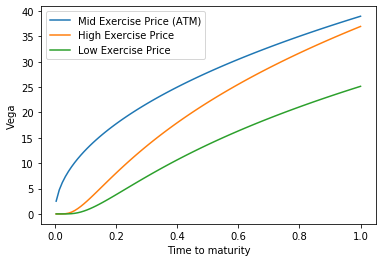

In [26]:
sa_vega2t = lambda option : tools.scenario_analysis(option, bs.vega, 
                                                    vrange = t_range, variable = 't')
call_vegas = sa_vega2t(call)
call_vegas_highK = sa_vega2t(call.shock(K_shock = 20))
call_vegas_lowK = sa_vega2t(call.shock(K_shock = -20))

# plot
plt.plot(t_range, call_vegas, label = 'Mid Exercise Price (ATM)')
plt.plot(t_range, call_vegas_highK, label = 'High Exercise Price')
plt.plot(t_range, call_vegas_lowK, label = 'Low Exercise Price')
plt.xlabel("Time to maturity")
plt.ylabel("Vega")
plt.legend()
plt.show()

### (4) Gamma

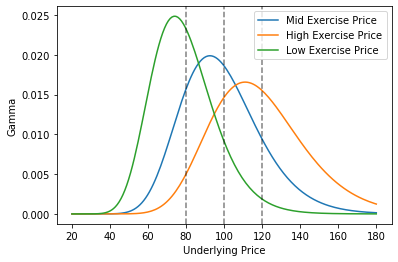

In [27]:
sa_gamma2S = lambda option : tools.scenario_analysis(option, bs.gamma, vrange = s_range)

call_gammas = sa_gamma2S(call)
call_gammas_highK = sa_gamma2S(call.shock(K_shock = 20))
call_gammas_lowK = sa_gamma2S(call.shock(K_shock = -20))

# plot
plt.plot(s_range, call_gammas, label = 'Mid Exercise Price')
plt.plot(s_range, call_gammas_highK, label = 'High Exercise Price')
plt.plot(s_range, call_gammas_lowK, label = 'Low Exercise Price')
plt.xlabel("Underlying Price")
plt.ylabel("Gamma")
plt.axvline(call.K, linestyle = 'dashed', color = 'black', alpha = 0.5)
plt.axvline(call.shock(K_shock = 20).K, linestyle = 'dashed', 
            color = 'black', alpha = 0.5)
plt.axvline(call.shock(K_shock = -20).K, linestyle = 'dashed', 
            color = 'black', alpha = 0.5)
plt.legend()
plt.show()

It is often stated that gamma has its peak ATM, but note this is not exactly true if the value strictly follows the Black-sholes model. As we can see in the graph above, gamma has its peak the underlying price is slightly less that the strike price.

The peak of a greek comes from the term $N'(d_1)$ (the pdf of a standard normal distribution) in many situations. When $d_1 = 0$, the pdf of a standard normal distribution takes its highest value. For ATM option, the term $ln(\frac{S}{K})$ is zero. However, the $(r-q+\frac{1}{2}\sigma^2)t$ part is generally greater than zero. Therefore, for $N'(d_1)$ to take its maximum, generally we need to have a slightly lower underlying price (the statement is not always true - it depends on the relationship between $r, q$ and $\sigma$).

With the statement above, we can analyze the peak of different greeks:

- **Gamma**: $\frac{e^{-qt}N'(d_1)}{S\sigma\sqrt{t}}$. Besides $N'(d_1)$, the $S$ term in denominator also means that the gamma value gets larger with slightly lower $S$. Therefore, it's definitely true that we need lower $S$ for gamma to take its highest value. 

- **Vega**: ${e^{-qt}N'(d_1)}{S\sqrt{t}}$. Different from gamma, the multiplicative $S$ term means that the vega value gets larger with higher $S$. Therefore, the different affects come from two factors can cancel out each other. As a result, vega can take its highest value around ATM.

- **Theta**: theta value for call and put is different. We take theta of a call as an example. $\Theta = -\frac{e^{-qt}S\sigma N'(d_1)}{2\sqrt{t}}+qSN(d_1)e^{-qt}-rKe^{-rt}N(d_2)$ is a little bit more complicated to analyze, but note that the second part and the third part only matters when the difference of $r$ and $q$ is very large of ATM option. If this is not true, what really matters is the first part $-\frac{e^{-qt}S\sigma N'(d_1)}{2\sqrt{t}}$, similar to vega, it should take its highest (absolute) value around ATM.

As a conclusion, under the most common situation (cost of carry for the underlying $r-q$ is positive or just slightly negative), the shift of peak away from ATM for vega and theta is not significant, but for gamma it can deviate quite a little bit.

The sensitivity of gamma to $S$, $\sigma$, and $t$ should be easy to analyze from the gamma formula given above. Then we take a look at these higher order greeks with graph.

The sensitivity of gamma to a change of underlying price is `speed`.

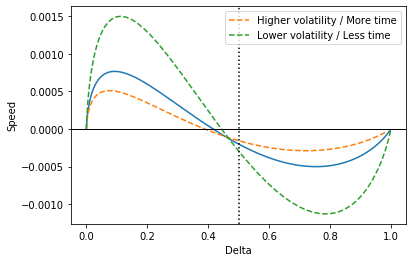

In [28]:
sa_speed2S = lambda option : tools.scenario_analysis(option, bs.speed, vrange = s_range)

call_speeds = sa_speed2S(call)
call_speeds_highvol = sa_speed2S(call.shock(sigma_shock = 0.1))
call_speeds_lowvol = sa_speed2S(call.shock(sigma_shock = -0.1))
call_deltas_highvol = sa_delta2S(call.shock(sigma_shock = 0.1))
call_deltas_lowvol = sa_delta2S(call.shock(sigma_shock = -0.1))

# plot
plt.plot(call_deltas, call_speeds)
plt.plot(call_deltas_highvol, call_speeds_highvol, linestyle = 'dashed', 
         label = 'Higher volatility / More time')
plt.plot(call_deltas_lowvol, call_speeds_lowvol, linestyle = 'dashed', 
         label = 'Lower volatility / Less time')
plt.xlabel("Delta")
plt.ylabel("Speed")
plt.axvline(0.5, linestyle = 'dotted', color = 'black')
plt.axhline(0, color = 'black', linewidth = 1)
plt.legend()
plt.show()

The sensitivity of gamma to passage of time is `color`.

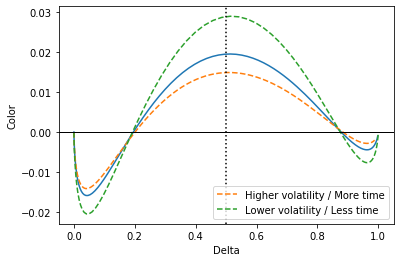

In [29]:
sa_color2S = lambda option : tools.scenario_analysis(option, bs.color, vrange = s_range)

call_colors = sa_color2S(call)
call_colors_highvol = sa_color2S(call.shock(sigma_shock = 0.1))
call_colors_lowvol = sa_color2S(call.shock(sigma_shock = -0.1))

# plot
plt.plot(call_deltas, call_colors)
plt.plot(call_deltas_highvol, call_colors_highvol, linestyle = 'dashed', 
         label = 'Higher volatility / More time')
plt.plot(call_deltas_lowvol, call_colors_lowvol, linestyle = 'dashed', 
         label = 'Lower volatility / Less time')
plt.xlabel("Delta")
plt.ylabel("Color")
plt.axvline(0.5, linestyle = 'dotted', color = 'black')
plt.axhline(0, color = 'black', linewidth = 1)
plt.legend()
plt.show()

The sensitivity of gamma to a change of volatility is `zomma`.

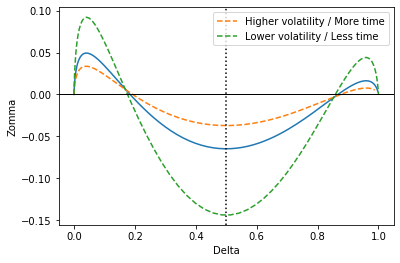

In [30]:
sa_zomma2S = lambda option : tools.scenario_analysis(option, bs.zomma, vrange = s_range)

call_zommas = sa_zomma2S(call)
call_zommas_highvol = sa_zomma2S(call.shock(sigma_shock = 0.1))
call_zommas_lowvol = sa_zomma2S(call.shock(sigma_shock = -0.1))

# plot
plt.plot(call_deltas, call_zommas)
plt.plot(call_deltas_highvol, call_zommas_highvol, linestyle = 'dashed', 
         label = 'Higher volatility / More time')
plt.plot(call_deltas_lowvol, call_zommas_lowvol, linestyle = 'dashed', 
         label = 'Lower volatility / Less time')
plt.xlabel("Delta")
plt.ylabel("Zomma")
plt.axvline(0.5, linestyle = 'dotted', color = 'black')
plt.axhline(0, color = 'black', linewidth = 1)
plt.legend()
plt.show()

### (5) Rho

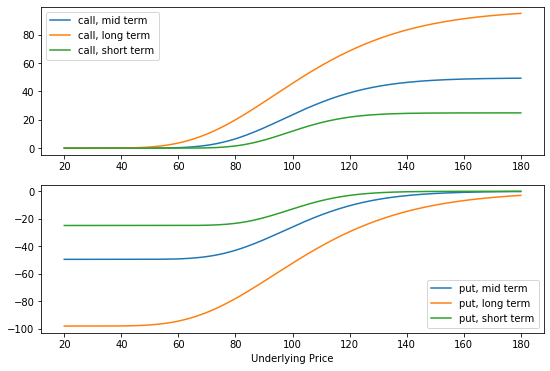

In [31]:
sa_rho2S = lambda option : tools.scenario_analysis(option, bs.rho, 
                                                   vrange = s_range)
call_rhos = sa_rho2S(call)
call_rhos_lt = sa_rho2S(call.set_param(param = 't', new_value = 1))
call_rhos_st = sa_rho2S(call.set_param(param = 't', new_value = 1/4))
put_rhos = sa_rho2S(put)
put_rhos_lt = sa_rho2S(put.set_param(param = 't', new_value = 1))
put_rhos_st = sa_rho2S(put.set_param(param = 't', new_value = 1/4))

# plot
fig, ax = plt.subplots(2,1, figsize = (9,6))
ax[0].plot(s_range, call_rhos, label = 'call, mid term')
ax[0].plot(s_range, call_rhos_lt, label = 'call, long term')
ax[0].plot(s_range, call_rhos_st, label = 'call, short term')
ax[0].legend()
ax[1].plot(s_range, put_rhos, label = 'put, mid term')
ax[1].plot(s_range, put_rhos_lt, label = 'put, long term')
ax[1].plot(s_range, put_rhos_st, label = 'put, short term')
plt.legend()
plt.xlabel("Underlying Price")
plt.show()

Key observations:

- Call option has positive rho while put option has negative rho. To replicate a call, essentially we are borrowing money to leverage a long underling position, so the higher interest rate, the higher the cost to replicate the call; to replicate a put, essentially we are shorting the underlying but spare some credit to invest in the money market, so the higher interest rate, the cheaper the put is. 

- As an option becomes more ITM, it becomes more sensitive to interest rate changes. This may seem counterintuitive - as an option goes ITM, it becomes more similar to the underlying and thus should have a rho decreasing to 0. The paradox is simply due to the fact that standard greeks including rho measure the sensitivity in dollar terms. As an option becomes more ITM, it also becomes more valuable. Then we'll take a look at how the percentage sensitivity changes.

- Longer term options are more sensitive. First it's true that the time span scale up the effect of interest; second the dollar value also increases as time to maturity increases. 

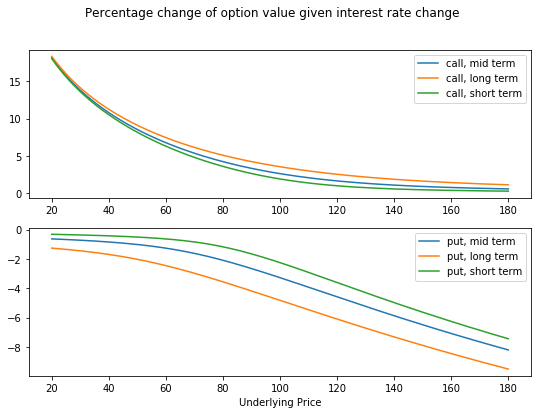

In [32]:
sa_rho2S_perct = lambda option :  tools.scenario_analysis(option, bs.rho, 
                                  vrange = s_range)/tools.scenario_analysis(option, 
                                  bs.pricing, vrange = s_range)
call_rhos_perct = sa_rho2S_perct(call)
call_rhos_perct_lt = sa_rho2S_perct(call.set_param(param = 't', new_value = 1))
call_rhos_perct_st = sa_rho2S_perct(call.set_param(param = 't', new_value = 1/4))
put_rhos_perct = sa_rho2S_perct(put)
put_rhos_perct_lt = sa_rho2S_perct(put.set_param(param = 't', new_value = 1))
put_rhos_perct_st = sa_rho2S_perct(put.set_param(param = 't', new_value = 1/4))

# plot
fig = plt.figure(figsize=(9,6))
fig.suptitle("Percentage change of option value given interest rate change")
ax = fig.add_subplot(211)
ax.plot(s_range, call_rhos_perct, label = 'call, mid term')
ax.plot(s_range, call_rhos_perct_lt, label = 'call, long term')
ax.plot(s_range, call_rhos_perct_st, label = 'call, short term')
ax.legend()
ax = fig.add_subplot(212)
ax.plot(s_range, put_rhos_perct, label = 'put, mid term')
ax.plot(s_range, put_rhos_perct_lt, label = 'put, long term')
ax.plot(s_range, put_rhos_perct_st, label = 'put, short term')
plt.legend()
plt.xlabel("Underlying Price")
plt.show()

`Phi`, sometime called `rho2`, is a less used greek. It means the sensitivity of option value to a change of dividend paying rate.

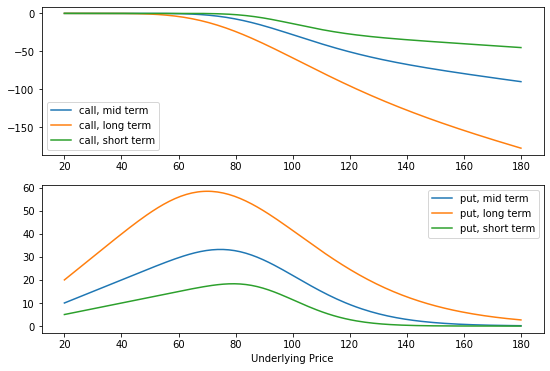

In [33]:
sa_phi2S = lambda option : tools.scenario_analysis(option, bs.phi, 
                                                   vrange = s_range)
call_phis = sa_phi2S(call)
call_phis_lt = sa_phi2S(call.set_param(param = 't', new_value = 1))
call_phis_st = sa_phi2S(call.set_param(param = 't', new_value = 1/4))
put_phis = sa_phi2S(put)
put_phis_lt = sa_phi2S(put.set_param(param = 't', new_value = 1))
put_phis_st = sa_phi2S(put.set_param(param = 't', new_value = 1/4))

# plot
fig, ax = plt.subplots(2,1, figsize = (9,6))
ax[0].plot(s_range, call_phis, label = 'call, mid term')
ax[0].plot(s_range, call_phis_lt, label = 'call, long term')
ax[0].plot(s_range, call_phis_st, label = 'call, short term')
ax[0].legend()
ax[1].plot(s_range, put_phis, label = 'put, mid term')
ax[1].plot(s_range, put_phis_lt, label = 'put, long term')
ax[1].plot(s_range, put_phis_st, label = 'put, short term')
plt.legend()
plt.xlabel("Underlying Price")
plt.show()

# Option Strategy

We often need to analyze the reward and risk of an option strategy/portfolio. The `Portfolio` class in the `options` module provides a way to do so. The counstructor for `Portfolo` requires two parameters:

- `option`: a list of the options in the portfolio.
- `share`: a list of the number of shares for the options in `option` list.

Now we use this class to analyze some frequently-used option strategies.

## 1. Straddle

A straddle consist of a call and it put counterpart. It's a strategy to long volatility.

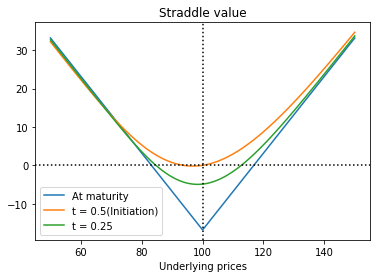

In [34]:
s_range = np.linspace(50, 150, num = 101)

straddle = options.Portfolio([call,put],[1,1])
current = copy.deepcopy(straddle)

pnl = current.final_payoff(s_range) - bs.pricing(current)
pnl_lt = tools.scenario_analysis(current, bs.pricing, vrange = s_range) - bs.pricing(current)
pnl_st = tools.scenario_analysis(current.set_param(param = 't', new_value = 1/4), 
                                 bs.pricing, vrange = s_range) - bs.pricing(current)

plt.plot(s_range, pnl, label = 'At maturity')
plt.plot(s_range, pnl_lt, label = 't = ' + str(call.t) + "(Initiation)")
plt.plot(s_range, pnl_st, label = 't = 0.25')

plt.xlabel('Underlying prices')
plt.title('Straddle as time passes')
plt.title('Straddle value')
plt.axvline(call.K, linestyle = 'dotted', color = 'black')
plt.axhline(color = 'black', linestyle = 'dotted')
plt.legend()
plt.show()

Note that with very low underlying prices, the position value even increases at time passes by. This is because for very low underlying prices, ITM put has positive theta, instead of a theta decay.

Traders frequently use straddle when they don't have a directional view but believe that the market would move rapidly. But is it true that a straddle is immune to directional change? Like how we use `tools.scenario_analysis` previously, we can also use this function in portfolio analysis. Here we take a look at the delta value. 

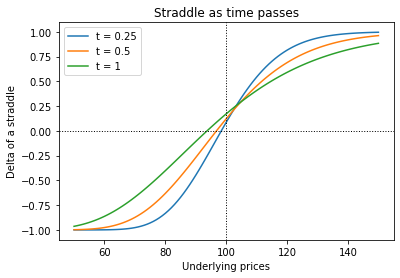

In [35]:
plt.plot(s_range, tools.scenario_analysis(straddle.set_param(param = 't', new_value = 0.25), 
                                          bs.delta, vrange = s_range), label = 't = 0.25')
plt.plot(s_range, tools.scenario_analysis(straddle, bs.delta, vrange = s_range),
        label = 't = ' + str(call.t))
plt.plot(s_range, tools.scenario_analysis(straddle.set_param(param = 't', new_value = 1), 
                                          bs.delta, vrange = s_range), label = 't = 1')

plt.xlabel('Underlying prices')
plt.ylabel('Delta of a straddle')
plt.title('Straddle as time passes')
plt.axvline(call.K, color = 'black', linewidth = 1, linestyle = 'dotted')
plt.axhline(color = 'black', linewidth = 1, linestyle = 'dotted')
plt.legend()
plt.show()

As we can see, even at the initial price, the delta is not exactly 0 but slightly higher. This is because the delta of a call/put is slightly higher than 0.5/-0.5 when the cost of carry is not extremly negative. When the underlying price goes up, the delta of a straddle increases to 1; when the underlying price drops, the delta decreases to -1. Therefore a straddle is not always insensitive to underlying price change. We need to rebalance if want to keep it delta-neutral.

Greeks are additive so we don't further illustrate other greeks for straddle here - they are simply the sum of greeks of a call and a put.

## 2. Strangle

A strangle also consists of a long position in a call and a put with the same maturity. But the options have different exercise prices.

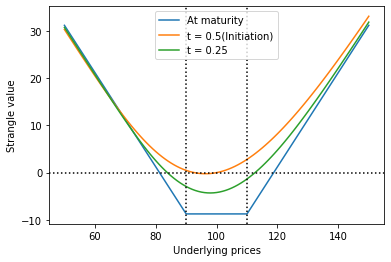

In [36]:
strangle = options.Portfolio([call_otm, put_otm])
current = copy.deepcopy(strangle)

pnl = current.final_payoff(s_range) - bs.pricing(current)
pnl_lt = tools.scenario_analysis(current, bs.pricing, vrange = s_range) - bs.pricing(current)
pnl_st = tools.scenario_analysis(current.set_param(param = 't', new_value = 1/4), 
                                 bs.pricing, vrange = s_range) - bs.pricing(current)

plt.plot(s_range, pnl, label = 'At maturity')
plt.plot(s_range, pnl_lt, label = 't = ' + str(call.t) + "(Initiation)")
plt.plot(s_range, pnl_st, label = 't = 0.25')

plt.xlabel('Underlying prices')
plt.ylabel('Strangle value')
plt.axvline(call_otm.K, linestyle = 'dotted', color = 'black')
plt.axvline(put_otm.K, linestyle = 'dotted', color = 'black')
plt.axhline(linestyle = 'dotted', color = 'black')
plt.legend()
plt.show()

We can compare the greeks of a straddle and a strangle.

In [37]:
greeks_summary = pd.DataFrame.from_dict(bs.greeks(straddle), orient = 'index', 
                       columns = ['straddle'])
greeks_summary['strangle'] = bs.greeks(strangle).values()

greeks_summary

,straddle,strangle
Delta,0.121765,0.125696
Gamma,0.037174,0.033226
Theta,-16.635165,-15.027950
Vega,55.760690,49.839002
Rho,-2.326053,1.906236
Speed,-0.000640,-0.000547
Vanna,0.154891,0.175547
Volga,-1.677984,35.201116
Charm,0.120815,0.119116
Color,0.038046,0.026616


A strangle is more conservertive than a straddle - it has lower gamma and vega.

## 3. Butterfly
A butterfly is a common three-sided spread consisting of options with equally spaced exercise prices. The options are of the same type and expire at the same time. In a long butterfly, the outside exercise prices are purchased are the inside is sold (with 2 shares). A long butterfly is shorting volatility while a short butterfly is longing volatility.

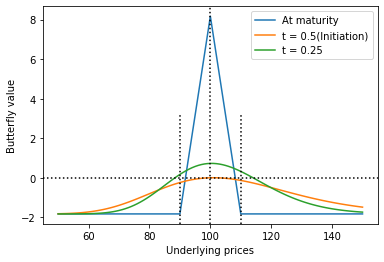

In [38]:
butterfly = options.Portfolio([call_itm, call, call_otm], [1,-2,1])
current = copy.deepcopy(butterfly)

pnl = current.final_payoff(s_range) - bs.pricing(current)
pnl_lt = tools.scenario_analysis(current, bs.pricing, vrange = s_range) - bs.pricing(current)
pnl_st = tools.scenario_analysis(current.set_param(param = 't', new_value = 1/4), 
                                 bs.pricing, vrange = s_range) - bs.pricing(current)

plt.plot(s_range, pnl, label = 'At maturity')
plt.plot(s_range, pnl_lt, label = 't = ' + str(call.t) + "(Initiation)")
plt.plot(s_range, pnl_st, label = 't = 0.25')

plt.xlabel('Underlying prices')

plt.ylabel('Butterfly value')
plt.axvline(call_itm.K, linestyle = 'dotted', color = 'black', ymax = 0.5)
plt.axvline(call.K, linestyle = 'dotted', color = 'black')
plt.axvline(call_otm.K, linestyle = 'dotted', color = 'black', ymax = 0.5)
plt.axhline(linestyle = 'dotted', color = 'black')
plt.legend()
plt.show()

## 4. Condor

Condor to butterfly is like strangle to sraddle. For the two options at the inside price, we have two options at two difference prices instead.

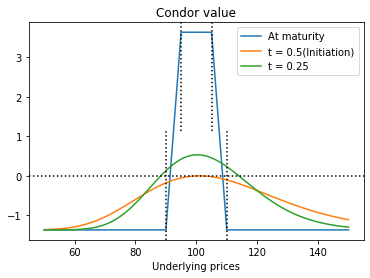

In [39]:
call_itm0 = call.shock(K_shock = -5)
call_otm0 = call.shock(K_shock = 5)
condor = options.Portfolio([call_itm, call_itm0, call_otm0, call_otm], 
                           [1,-1,-1,1])
current = copy.deepcopy(condor)

pnl = current.final_payoff(s_range) - bs.pricing(current)
pnl_lt = tools.scenario_analysis(current, bs.pricing, vrange = s_range) - bs.pricing(current)
pnl_st = tools.scenario_analysis(current.set_param(param = 't', new_value = 1/4), 
                                 bs.pricing, vrange = s_range) - bs.pricing(current)

plt.plot(s_range, pnl, label = 'At maturity')
plt.plot(s_range, pnl_lt, label = 't = ' + str(call.t) + "(Initiation)")
plt.plot(s_range, pnl_st, label = 't = 0.25')

plt.xlabel('Underlying prices')

plt.title('Condor value')
plt.axvline(call_itm.K, linestyle = 'dotted', color = 'black', ymax = 0.5)
plt.axvline(call_itm0.K, linestyle = 'dotted', color = 'black', ymin = 0.5)
plt.axvline(call_otm0.K, linestyle = 'dotted', color = 'black', ymin = 0.5)
plt.axvline(call_otm.K, linestyle = 'dotted', color = 'black', ymax = 0.5)
plt.axhline(linestyle = 'dotted', color = 'black')
plt.legend()
plt.show()

## 5. Call ratio spread
Straddle has unlimited risks/profits on both side while butterfly has limited risks/profits on both side. We can also use a ratio spread if we want to take unlimited risk on one side and limited risk on the other side. We can either do a call ratio spread or a put ratio spread. We use a call ratio spread as an example to illustrate. It only consists of call options. The number of shares are chosen so that it's almost delta neutral.

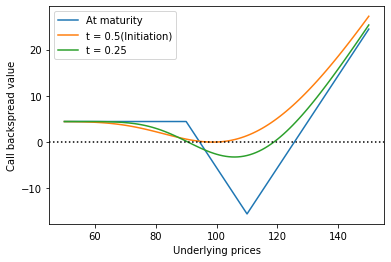

In [40]:
ratio_backspread = options.Portfolio([call_otm, call_itm],[2,-1]) 
current = copy.deepcopy(ratio_backspread)

pnl = current.final_payoff(s_range) - bs.pricing(current)
pnl_lt = tools.scenario_analysis(current, bs.pricing, vrange = s_range) - bs.pricing(current)
pnl_st = tools.scenario_analysis(current.set_param(param = 't', new_value = 1/4), 
                                 bs.pricing, vrange = s_range) - bs.pricing(current)

plt.plot(s_range, pnl, label = 'At maturity')
plt.plot(s_range, pnl_lt, label = 't = ' + str(call.t) + "(Initiation)")
plt.plot(s_range, pnl_st, label = 't = 0.25')

plt.xlabel('Underlying prices')
plt.ylabel('Call backspread value')
plt.axhline(color = 'black', linestyle = 'dotted')
plt.legend()
plt.show()

In [41]:
bs.greeks(ratio_backspread)

{'Delta': 0.025045971788884014,
 'Gamma': 0.02077327202530252,
 'Theta': -9.486843139727787,
 'Vega': 31.15990803795378,
 'Rho': 3.4717682085413415,
 'Speed': 0.0007612081328418576,
 'Vanna': 1.765010360021862,
 'Volga': 5.427797842921255,
 'Charm': 0.5710496520571636,
 'Color': 0.017749830750528498,
 'Zomma': -0.06562570818906088,
 'Phi': -1.2522985894442016}

When more option are purchasing than selling, it's called backspread; otherwise it's called frontspread.

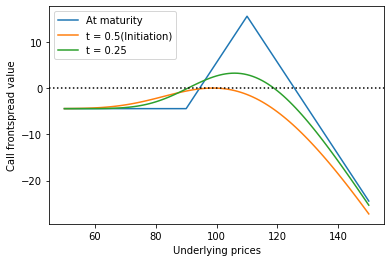

In [42]:
ratio_frontspread = options.Portfolio([call_otm, call_itm],[-2,1]) 
current = copy.deepcopy(ratio_frontspread)

pnl = current.final_payoff(s_range) - bs.pricing(current)
pnl_lt = tools.scenario_analysis(current, bs.pricing, vrange = s_range) - bs.pricing(current)
pnl_st = tools.scenario_analysis(current.set_param(param = 't', new_value = 1/4), 
                                 bs.pricing, vrange = s_range) - bs.pricing(current)

plt.plot(s_range, pnl, label = 'At maturity')
plt.plot(s_range, pnl_lt, label = 't = ' + str(call.t) + "(Initiation)")
plt.plot(s_range, pnl_st, label = 't = 0.25')

plt.xlabel('Underlying prices')
plt.ylabel('Call frontspread value')
plt.axhline(color = 'black', linestyle = 'dotted')
plt.legend()
plt.show()

## 6. Christmas tree

Christmas trees (also referred to as *ladders*) to strangles is like ratio spreads to straddles.

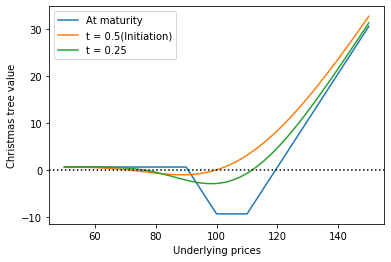

In [43]:
ladder = options.Portfolio([call_itm, call, call_otm],[-1,1,1]) 
current = copy.deepcopy(ladder)

pnl = current.final_payoff(s_range) - bs.pricing(current)
pnl_lt = tools.scenario_analysis(current, bs.pricing, vrange = s_range) - bs.pricing(current)
pnl_st = tools.scenario_analysis(current.set_param(param = 't', new_value = 1/4), 
                                 bs.pricing, vrange = s_range) - bs.pricing(current)

plt.plot(s_range, pnl, label = 'At maturity')
plt.plot(s_range, pnl_lt, label = 't = ' + str(call.t) + "(Initiation)")
plt.plot(s_range, pnl_st, label = 't = 0.25')

plt.xlabel('Underlying prices')
plt.ylabel('Christmas tree value')
plt.axhline(color = 'black', linestyle = 'dotted')
plt.legend()
plt.show()

## 7. Calendar spread

Calendar spreads, sometimes referred to as *time spreads* or *horizontal spreads* consisit of options that expire in different months. The most common calendar spread consists of opposing positions in two options of the same type and exercise price.

Note that in this portfolio, options have different maturities, but the `final_payoff` method in the `Portfolio` class gives the payoff with certain underlying prices after **all** options mature. Therefore, if we are interested in the payoff after the short-term option expires. We should use `bs.pricing` with a time shock equals to `-t`, where `t` is the time-to-maturity parameter of the short-term option. When `bs.pricing` has an option with `t=0`, it calls the `final_payoff` function instead.

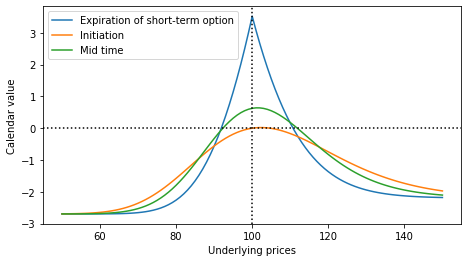

In [44]:
call_st = call.set_param(param = 't', new_value = 1/4)
calendar = options.Portfolio([call, call_st],[1,-1]) 
current = copy.deepcopy(calendar)

pnl_init = tools.scenario_analysis(current, bs.pricing, vrange = s_range) - bs.pricing(current)
pnl_mid = tools.scenario_analysis(current.shock(t_shock = -call_st.t*0.5), 
                                  bs.pricing, vrange = s_range) - bs.pricing(current)
pnl_exp = tools.scenario_analysis(current.shock(t_shock = -call_st.t), 
                                  bs.pricing, vrange = s_range) - bs.pricing(current)


plt.figure(figsize = (7.5,4))
plt.plot(s_range, pnl_exp, label = 'Expiration of short-term option')
plt.plot(s_range, pnl_init, label = 'Initiation')
plt.plot(s_range, pnl_mid, label = 'Mid time')

plt.xlabel('Underlying prices')
plt.ylabel('Calendar value')
plt.axhline(color = 'black', linestyle = 'dotted')
plt.axvline(call.K, color = 'black', linestyle = 'dotted')
plt.legend(loc = 2)
plt.show()

The spreads we discuss earlier all long both Gamma and Vega if we take the "long volatility" position. But for calendar spread, if we take a "long volatility" position (buy short-term and sell long-term; short the standard calendar spread), we long gamma but short vega.

In [45]:
print("Gamma: ", round(-bs.gamma(calendar),4))
print("Vega: ", round(-bs.vega(calendar),4))
print("Theta: ", round(-bs.theta(calendar),4))

Gamma:  0.0079
Vega:  -8.0499
Theta:  -3.5526


To further understand this, we can have a look at how the volatility influence our calendar spread strategy in the graph above.

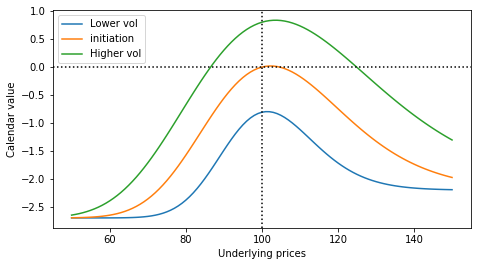

In [46]:
pnl_midvol = tools.scenario_analysis(current, bs.pricing, vrange = s_range) - bs.pricing(current)
pnl_lowvol = tools.scenario_analysis(current.shock(sigma_shock = -0.1), 
                                  bs.pricing, vrange = s_range) - bs.pricing(current)
pnl_highvol = tools.scenario_analysis(current.shock(sigma_shock = 0.1),
                                  bs.pricing, vrange = s_range) - bs.pricing(current)

plt.figure(figsize = (7.5,4))
plt.plot(s_range, pnl_lowvol, label = 'Lower vol')
plt.plot(s_range, pnl_midvol, label = 'initiation')
plt.plot(s_range, pnl_highvol, label = 'Higher vol')

plt.xlabel('Underlying prices')
plt.ylabel('Calendar value')
plt.axhline(color = 'black', linestyle = 'dotted')
plt.axvline(call.K, color = 'black', linestyle = 'dotted')
plt.legend(loc = 2)
plt.show()

As we can see, although this portfolio is shorting *realized future volatility*, it longs *implied volatility*. If the implied volatility goes up, our position benefits from it.

## 8. Time butterfly

Time butterfly consists of options at the same strike price but with three different expiration dates, so it's like a butterfly but the different parameters among the options is the time to maturity instead of the strike price.

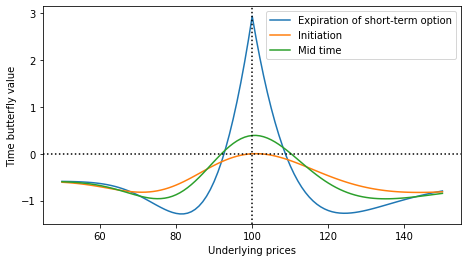

In [47]:
call_lt = call.set_param(param = 't', new_value = 3/4)
timefly = options.Portfolio([call, call_st, call_lt], [2, -1, -1])

current = copy.deepcopy(timefly)

pnl_init = tools.scenario_analysis(current, bs.pricing, vrange = s_range) - bs.pricing(current)
pnl_mid = tools.scenario_analysis(current.shock(t_shock = -call_st.t*0.5), 
                                  bs.pricing, vrange = s_range) - bs.pricing(current)
pnl_exp = tools.scenario_analysis(current.shock(t_shock = -call_st.t), 
                                  bs.pricing, vrange = s_range) - bs.pricing(current)


plt.figure(figsize = (7.5,4))
plt.plot(s_range, pnl_exp, label = 'Expiration of short-term option')
plt.plot(s_range, pnl_init, label = 'Initiation')
plt.plot(s_range, pnl_mid, label = 'Mid time')

plt.xlabel('Underlying prices')
plt.ylabel('Time butterfly value')
plt.axhline(color = 'black', linestyle = 'dotted')
plt.axvline(call.K, color = 'black', linestyle = 'dotted')
plt.legend()
plt.show()

## 9. Vertical spread

For the spreads we talk about above, they focus primarily on estimation of volatility. We can take a ratioed position if we have a directional view. But if we are wrong about the volatility estimation, the spread may not retain the characteristics we originally intended. 

If we focus primarily on the direction change of the market, we can construct a vertical spread. The typical examples are *bull spread* and *bear spread*.

A bull spread can be constructed by selling an option with a higher strike price while buying an option with a lower strike price. Both call and put option can be used to construct a bull spread.

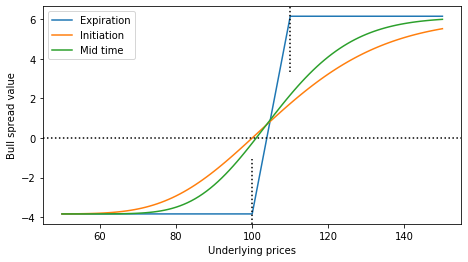

In [48]:
bull = options.Portfolio([call, call_otm], [1, -1])

current = copy.deepcopy(bull)

pnl_init = tools.scenario_analysis(current, bs.pricing, vrange = s_range) - bs.pricing(current)
pnl_mid = tools.scenario_analysis(current.shock(t_shock = -call.t*0.5), 
                                  bs.pricing, vrange = s_range) - bs.pricing(current)
pnl_exp = tools.scenario_analysis(current.shock(t_shock = -call.t), 
                                  bs.pricing, vrange = s_range) - bs.pricing(current)


plt.figure(figsize = (7.5,4))
plt.plot(s_range, pnl_exp, label = 'Expiration')
plt.plot(s_range, pnl_init, label = 'Initiation')
plt.plot(s_range, pnl_mid, label = 'Mid time')

plt.xlabel('Underlying prices')
plt.ylabel('Bull spread value')
plt.axhline(color = 'black', linestyle = 'dotted')
plt.axvline(call.K, color = 'black', linestyle = 'dotted', ymax = 0.3)
plt.axvline(call_otm.K, color = 'black', linestyle = 'dotted', ymin = 0.7)
plt.legend()
plt.show()

On the other hand, a bear spread is constructed by selling an option with a lower strike price while buying an option with a higher strike price.  

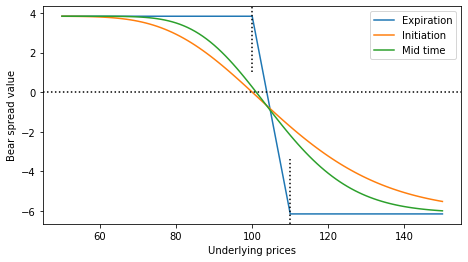

In [49]:
bear = options.Portfolio([call, call_otm], [-1, 1])

current = copy.deepcopy(bear)

pnl_init = tools.scenario_analysis(current, bs.pricing, vrange = s_range) - bs.pricing(current)
pnl_mid = tools.scenario_analysis(current.shock(t_shock = -call.t*0.5), 
                                  bs.pricing, vrange = s_range) - bs.pricing(current)
pnl_exp = tools.scenario_analysis(current.shock(t_shock = -call.t), 
                                  bs.pricing, vrange = s_range) - bs.pricing(current)


plt.figure(figsize = (7.5,4))
plt.plot(s_range, pnl_exp, label = 'Expiration')
plt.plot(s_range, pnl_init, label = 'Initiation')
plt.plot(s_range, pnl_mid, label = 'Mid time')

plt.xlabel('Underlying prices')
plt.ylabel('Bear spread value')
plt.axhline(color = 'black', linestyle = 'dotted')
plt.axvline(call.K, color = 'black', linestyle = 'dotted', ymin = 0.7)
plt.axvline(call_otm.K, color = 'black', linestyle = 'dotted', ymax = 0.3)
plt.legend()
plt.show()

# Case Study - Position Analysis

In the final part, we take about how to analyze some more complex position.

First, let's consider about a position that consist of a bull spread, a short position of time butterfly, and a short position of a condor. The condor and time butterfly both consist of four options (two long and two short) while the bull spread only consists of two options as the example above. First, let's construct these sub-strategies. The options involved have three different time to maturities: 0.25, 0.5, and 0.75; and five different strike prices around the underlying prices 100. Let's assume the current underlying price is 100.

In [50]:
bull = options.Portfolio([call_itm0.shock(t_shock = -0.25), 
                          call_itm.shock(t_shock = -0.25)], [-1, 1])
timefly = options.Portfolio([call, call_st, call_lt], [2, -1, -1])
condor = condor = options.Portfolio([call_itm, call_itm0, call_otm0, call_otm], 
                           [1,-1,-1,1])

To get this synthetic portfolio. We can use `+`,`-`,`*` operators. They are overloaded in the `Portfolio` class.

In [51]:
port = bull - 2*timefly - 2*condor

Then we can have a look at its characteristics. First take a look at the greeks.

In [52]:
bs.greeks(port)

{'Delta': 0.10363018975874094,
 'Gamma': 0.009662408493168358,
 'Theta': -4.565510810800678,
 'Vega': 1.1279539935706993,
 'Rho': 2.5102729980172,
 'Speed': -0.0005545412865538053,
 'Vanna': -0.31753205651817673,
 'Volga': -36.46457923946399,
 'Charm': -0.14325708552436056,
 'Color': 0.04531562741351815,
 'Zomma': -0.04455632731664279,
 'Phi': -3.808478501329958}

As we can see, this position has positive delta so we are betting on an up move. Theta is negative so we have time decay. Gamma and Vega is positive so we can benefit from volatility increases. But note these greeks only tell us how the value of our position changes at the current point. If we have a large maket shock, the first-order greeks are not a good estimate for the change of portfoio value. If we want to have a more comprehensive understanding of our portfolio, we should look at higher order greeks or do some graph analysis.

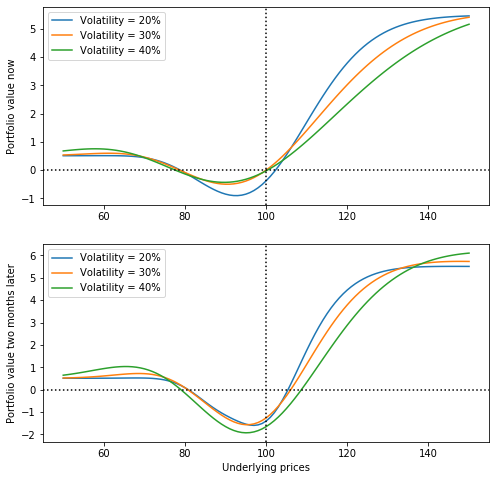

In [53]:
current = copy.deepcopy(port)
target_func = bs.pricing

pnl = tools.scenario_analysis(current, bs.pricing, vrange = s_range) - bs.pricing(current)
pnl_lowvol = tools.scenario_analysis(current.shock(sigma_shock = -0.1), 
                                  bs.pricing, vrange = s_range) - bs.pricing(current)
pnl_highvol = tools.scenario_analysis(current.shock(sigma_shock = 0.1), 
                                  bs.pricing, vrange = s_range) - bs.pricing(current)

pnl_2m = tools.scenario_analysis(current.shock(t_shock = -2/12), 
                                 bs.pricing, vrange = s_range) - bs.pricing(current)
pnl_lowvol_2m = tools.scenario_analysis(current.shock(sigma_shock = -0.1, t_shock = -2/12), 
                                  bs.pricing, vrange = s_range) - bs.pricing(current)
pnl_highvol_2m = tools.scenario_analysis(current.shock(sigma_shock = 0.1, t_shock = -2/12), 
                                  bs.pricing, vrange = s_range) - bs.pricing(current)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(211)
ax.plot(s_range, pnl_lowvol, label = 'Volatility = 20%')
ax.plot(s_range, pnl, label = 'Volatility = 30%')
ax.plot(s_range, pnl_highvol, label = 'Volatility = 40%')
ax.set_ylabel('Portfolio value now')
ax.axhline(color = 'black', linestyle = 'dotted')
ax.axvline(call.S, color = 'black', linestyle = 'dotted')
ax.legend()

ax = fig.add_subplot(212)
ax.plot(s_range, pnl_lowvol_2m, label = 'Volatility = 20%')
ax.plot(s_range, pnl_2m, label = 'Volatility = 30%')
ax.plot(s_range, pnl_highvol_2m, label = 'Volatility = 40%')
ax.set_ylabel('Portfolio value two months later')
ax.axhline(color = 'black', linestyle = 'dotted')
ax.axvline(call.S, color = 'black', linestyle = 'dotted')
ax.legend()
plt.xlabel('Underlying prices')


plt.legend()
plt.show()

As we can see from the graph. A market downturn isn't always bad for us. Actually a large downturn of more than 20% can benefit us. This is because we have positive gamma, so when market drops, delta can also drop to a negative value. Also note that with lower volatility, the curve has greater curvature, which means the gamma is magnified. This phenomenon is reflected in the negative zomma - as volatility goes down, gamma increases. 

On the other side, market increases are generally even better, especially if it quite large and comes with a drop in the implied volatility. Again, a drop in volatility means higher gamma since we have negative zomma. Therefore, with market increases, the delta also increases faster, resulting in a higher portfolio value. But a drop in implied volatility itself hurts our portfolio, so if the underlying price dosn't increase so much, a drop in volatility is worse than no change in volatility. But as the underlying price increases more, a lower volatility would be better.

Things can also be a little different two months from now, even with the same shock. We can do similar analysis on this graph.

Similar to how we analyze the P&L, we can also analyze how delta and vega change with different underlying prices and volatilities.

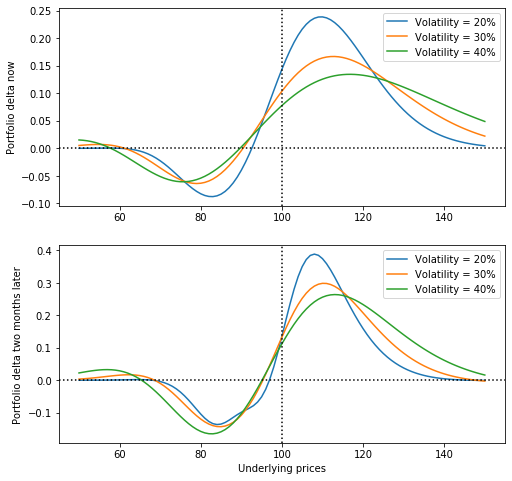

In [57]:
# because of the code reuse, let's define a function for our situation

def tmp_analyze(port, target_func, name):
    res = tools.scenario_analysis(port, target_func, vrange = s_range) 
    res_lowvol = tools.scenario_analysis(port.shock(sigma_shock = -0.1), 
                                      target_func, vrange = s_range)
    res_highvol = tools.scenario_analysis(port.shock(sigma_shock = 0.1), 
                                      target_func, vrange = s_range) 
    res_2m = tools.scenario_analysis(port.shock(t_shock = -2/12), 
                                     target_func, vrange = s_range) 
    res_lowvol_2m = tools.scenario_analysis(port.shock(sigma_shock = -0.1, t_shock = -2/12), 
                                      target_func, vrange = s_range)
    res_highvol_2m = tools.scenario_analysis(port.shock(sigma_shock = 0.1, t_shock = -2/12), 
                                      target_func, vrange = s_range) 

    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(211)
    ax.plot(s_range, res_lowvol, label = 'Volatility = 20%')
    ax.plot(s_range, res, label = 'Volatility = 30%')
    ax.plot(s_range, res_highvol, label = 'Volatility = 40%')
    ax.set_ylabel('Portfolio ' + name + ' now')
    ax.axhline(color = 'black', linestyle = 'dotted')
    ax.axvline(call.S, color = 'black', linestyle = 'dotted')
    ax.legend()

    ax = fig.add_subplot(212)
    ax.plot(s_range, res_lowvol_2m, label = 'Volatility = 20%')
    ax.plot(s_range, res_2m, label = 'Volatility = 30%')
    ax.plot(s_range, res_highvol_2m, label = 'Volatility = 40%')
    ax.set_ylabel('Portfolio ' + name + ' two months later')
    ax.axhline(color = 'black', linestyle = 'dotted')
    ax.axvline(call.S, color = 'black', linestyle = 'dotted')
    ax.legend()
    plt.xlabel('Underlying prices')
    plt.legend()
    plt.show()
    
tmp_analyze(current, bs.delta, 'delta')

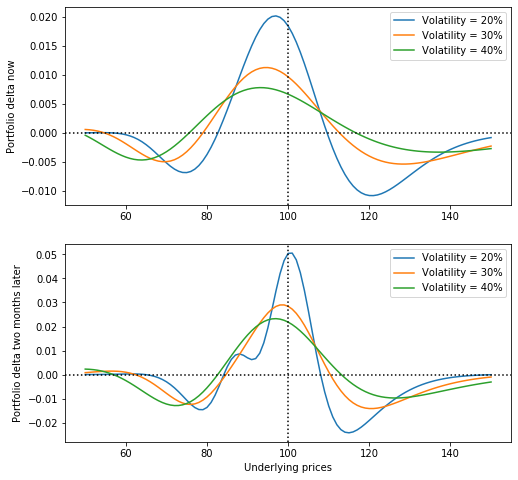

In [58]:
tmp_analyze(current, bs.gamma, 'delta')

Following this template, we can analyze other greeks we are interested in under different situations. We can use these graphs to give us a better understanding of our portfolio.

# Reference

Hull, J. (2018). *Options, futures, and other derivatives.* New York, NY: Pearson. 

Natenberg, S. (2015). *Option volatility and pricing: advanced trading strategies and techniques.* New York: McGraw-Hill Education.

Haug, E. G. (2007). *The complete guide to option pricing formulas.* New York: McGraw-Hill. 